In [56]:
# This one shows off LEFTRIGHT case on "A1 AGGREGATES"
# and spreadclosest() on 'B1 CVM OUTPUT'


import os
import xlutils
import databaker
import databaker.constants
from databaker.constants import *
import xypath
import databaker.databakersolo as ds
from databaker.jupybakeutils import savepreviewhtml, writetechnicalCSV, procrows, TechnicalCSV, yield_dimension_values
Dcelllookup = ds.overrides.Dcelllookup
batchcelllookup = ds.overrides.batchcelllookup


In [57]:
inputfile = "gdpq3m2reftables_tcm77-425649.xls"
outputfile = "%s.csv" % os.path.splitext(inputfile)[0]
previewfile = "preview.html"


In [58]:
print("Loading %s which has size %d bytes" % (inputfile, os.path.getsize(inputfile)))
tableset = xypath.loader.table_set(inputfile, extension='xls')
tabs = list(xypath.loader.get_sheets(tableset, "*"))
print("Table names", [tab.name  for tab in tabs])


Loading gdpq3m2reftables_tcm77-425649.xls which has size 2115072 bytes
Table names ['Content', 'Index', 'A1 AGGREGATES', 'A2 AGGREGATES', 'B1 CVM OUTPUT', 'B2 CVM OUTPUT', 'C1 EXPENDITURE', 'C2 EXPENDITURE', 'D INCOME', 'H1 TRADE', 'H2 TRADE', 'L GVAbp', 'M Alignment adjustments', 'N Financial Year Variables', 'O Selected imp def', 'P GDP per head']


In [ ]:
# new function for matching up the leftright case
def spreadclosest(bag, subbag):
    for cell in bag:
        if cell not in subbag:
            scell = min(subbag, key=lambda scell: (max(abs(cell.x-scell.x), abs(cell.y-scell.y)), scell.y, scell.x))
            cell._cell.value = scell.value


In [68]:
conversionsegments = [ ]

for tab in tabs:
    
    if tab.name != "A1 AGGREGATES": 
        continue
    print("looking at", tab.name)
    
    skipcount = 2 if tab.name in ['B1 CVM OUTPUT', 'B2 CVM OUTPUT'] else 1
    anchor = tab.excel_ref('A2').expand(DOWN).is_not_blank().is_not_whitespace().by_index(skipcount)
    obs = anchor.fill(RIGHT).expand(DOWN).is_not_blank().is_not_whitespace()
    obs = obs - tab.excel_ref('B2').expand(DOWN).is_not_blank().is_not_whitespace().expand(RIGHT).expand(LEFT).expand(DOWN)        
        
    if tab.name in ["A1 AGGREGATES", "A2 AGGREGATES"]:
        anchor = tab.excel_ref('A2').expand(DOWN).is_not_blank().is_not_whitespace().by_index(1)
        obs = anchor.fill(RIGHT).expand(DOWN).is_not_blank().is_not_whitespace()
        obs = obs - tab.excel_ref('B2').expand(DOWN).is_not_blank().is_not_whitespace().expand(RIGHT).expand(LEFT).expand(DOWN)        
        
        dimensions = [ 
            (tab.excel_ref('A3').expand(RIGHT).is_not_blank().is_not_whitespace(), "Cat1", DIRECTLY, ABOVE), 
            (tab.excel_ref('A2').expand(RIGHT).is_not_blank().is_not_whitespace().parent(), "Cat2", CLOSEST, LEFTRIGHT), 
        ]
    elif tab.name in ['B1 CVM OUTPUT']:
        cat2 = tab.excel_ref('A3').expand(RIGHT).is_not_blank().is_not_whitespace() 
        cat1 = cat2.shift(UP)
        cat1r = cat1.is_not_whitespace()
        spreadclosest(cat1, cat1r)
        #cat2 = tab.excel_ref('A2').expand(RIGHT).is_not_blank().is_not_whitespace().parent()
        dimensions = [ 
            (cat1, "Cat1", DIRECTLY, ABOVE), 
            (cat2, "Cat2", DIRECTLY, ABOVE), 
        ]
    elif tab.name in ['B2 CVM OUTPUT']:
        cat2 = tab.excel_ref('A3').expand(RIGHT).is_not_blank().is_not_whitespace() 
        dimensions = [ 
            (cat2, "Cat2", DIRECTLY, ABOVE), 
        ]
    else:
        continue

    # further dimensions common to all pages
    dimensions.append((anchor.expand(DOWN).is_not_blank().is_not_whitespace().is_not_bold(), TIME, DIRECTLY, LEFT))

    mtype = { 'A1 AGGREGATES':'Number', 'A2 AGGREGATES':'Value', 'B1 CVM OUTPUT':'Number', 'B2 CVM OUTPUT':'Number', 'C1 EXPENDITURE':'Value', 'C2 EXPENDITURE':'Value',  
               'D INCOME':'Value', 'L GVAbp':'Number', 'M Alignment adjustments':'Value', 'N Financial Year Variables':'Value', 'O Selected imp def':'Number', 
               'P GDP per head':'Number', 'H1 TRADE':'Value' ,'H2 TRADE':'Value'}   
    dimensions.append((mtype[tab.name], MEASURETYPE, None, None))

    if tab.name == 'C1 EXPENDITURE':
        dimensions.append(('£ million', UNITOFMEASURE, None, None))
    if tab.name == 'C2 EXPENDITURE':
        dimensions.append(('Reference year 2012, £ million', UNITOFMEASURE, None, None))

    cdid_horizontal = anchor.shift(UP).fill(RIGHT).is_not_blank().is_not_whitespace()       
    cdid_vertical = anchor.expand(DOWN).is_blank()
    cdid = cdid_horizontal.waffle(cdid_vertical).is_not_blank().is_not_whitespace() | cdid_horizontal
    obs = obs - cdid
    obs = obs - obs.filter(contains_string('-'))
    dimensions.append((cdid, 'CDID', DIRECTLY, ABOVE))
    dimensions.append((anchor.expand(DOWN).is_not_blank().is_not_whitespace().is_bold(), 'Output', CLOSEST, ABOVE))    

    conversionsegments.append((tab, dimensions, obs))
    
# this is the preview system
conversionsegment = conversionsegments[-1]
savepreviewhtml(conversionsegment, batchcelllookup, previewfile)


looking at B2 CVM OUTPUT
opening file preview.html
table written
javascript calculated


In [70]:
print("converting and writing %d conversion segments into %s" % (len(conversionsegments), outputfile))
convertedrows = [ ]
for conversionsegment in conversionsegments:
    print("conversion segment size %d" % len(conversionsegment[2]))
    rows = procrows(conversionsegment, batchcelllookup)
    convertedrows.append(rows)

# here we can do further sorting and substitution   


csvout = TechnicalCSV(outputfile, False)
for rows, conversionsegment in zip(convertedrows, conversionsegments):
    headernames = [None]+[dimension[1]  for dimension in conversionsegment[1]  if type(dimension[1]) != int ]
    for row in rows:
        values = dict((k if type(k)==int else headernames.index(k), v)  for k, v in row.items())
        output_row = yield_dimension_values(values, headernames)
        csvout.output(output_row)
csvout.footer()



converting and writing 1 conversion segments into gdpq3m2reftables_tcm77-425649.csv
conversion segment size 2776


In [73]:
len(convertedrows[0])
convertedrows[0][:10]

[{'Cat2': 'Wholesale and retail trade',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2NE',
  -9: 83.6,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Transport, storage and communications',
  'Output': 'Seasonally adjusted',
  'CDID': 'KI8M',
  -9: 56.7,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Accommodation and food services',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2NQ',
  -9: 70.3,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Financial and insurance activities',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2O6',
  -9: 64.5,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Real estate',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2OC',
  -9: 65.0,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Professional, scientific administration and support',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2OH',
  -9: 48.5,
  -6: 'Number',
  -2: 1997.0},
 {'Cat2': 'Public administration, national defence, social security',
  'Output': 'Seasonally adjusted',
  'CDID': 'L2P8',
  -9: 91.3,
  -6: 'Number',

<IPython.core.display.Javascript object>


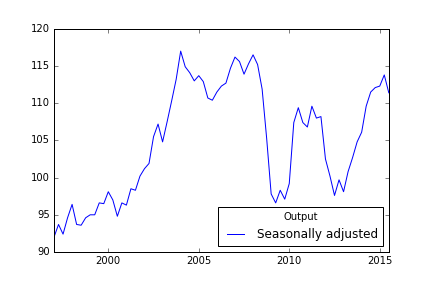

<IPython.core.display.Javascript object>


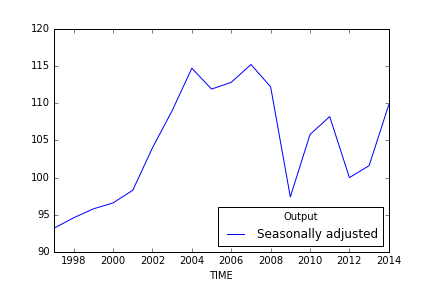

In [79]:


# alternatively, using pivot table (made by Peter)
import pandas as pd
df = ( 
    pd.DataFrame.from_records(convertedrows[0])
    .rename(columns={-6:"MEASURETYPE", -2:"TIME", -9:"OBS"})
    #.assign(TIME=lambda df:[t[:4]  for t in df.TIME])
    #.assign(TIME2=lambda df:df.TIME.astype(int)*2)
)

pdf = df.pivot_table("OBS", ["TIME"], ["CDID", "Output"])

%matplotlib notebook 
k = pdf.L2N8.select(lambda X:type(X) == str)
import re
def q(X):
    m = re.match("(\d\d\d\d) Q(\d)", X)
    return int(m.group(1))+0.25*(int(m.group(2)) - 1)
k.index = pd.Index(q(i)  for i in k.index)
k.plot()
k1 = pdf.L2N8.select(lambda X:type(X) == float)
k1.plot()



In [80]:
1


1